#code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
! git clone https://github.com/jamescporter/MACH-implementation.git
%cd /content/MACH-implementation



Cloning into 'MACH-implementation'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), done.
/content/MACH-implementation


In [ ]:
!ls /content/drive/MyDrive/DAI_PROJECT/AmazonTitles-670KK/AmazonTitles-670K/

fasttextB_embeddings_300d.npy  trn_X_Y.txt   tst_X_Y.txt
trn_X_Xf.txt		       tst_X_Xf.txt  Xf.txt


In [ ]:
!head -n 5 /content/drive/MyDrive/DAI_PROJECT/AmazonTitles-670KK/AmazonTitles-670K/trn_X_Xf.txt

485176 66666
8215:7.391338348388672 10957:6.684897899627686 30148:10.49216079711914 39753:13.00446605682373 42349:5.1744384765625 57533:7.202347755432129
2215:6.336237907409668 10481:9.220276832580566 28348:9.812619209289551 40104:9.944195747375488 40426:7.49913501739502 44141:5.685484886169434 44461:4.555766105651855 44464:8.519582748413086 51124:9.913423538208008 55921:11.21270656585693
2215:6.336237907409668 14303:6.337085723876953 32110:9.05322265625 34460:14.89270401000977 40475:10.41419887542725 47108:7.937660694122314 66524:10.49216079711914
25178:8.032341003417969 30856:9.411730766296387 47610:9.066125869750977


In [ ]:
!head -n 5 /content/drive/MyDrive/DAI_PROJECT/AmazonTitles-670KK/AmazonTitles-670K/trn_X_Y.txt

485176 670091
34141:1 119299:1 126600:1 128716:1 187372:1 218742:1
465536:1 465553:1 615429:1
393828:1
167614:1 223686:1


##task1

In [ ]:
!pip install captum

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from captum.attr import IntegratedGradients
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Dataset Paths
DATA_DIR = "/kaggle/input/lightxml-dataset/Amazon-670K/Amazon-670K"
train_features_file = f"{DATA_DIR}/train_v1.txt"
train_labels_file = f"{DATA_DIR}/train_labels.txt"
test_features_file = f"{DATA_DIR}/test_v1.txt"
test_labels_file = f"{DATA_DIR}/test_labels.txt"

# Configuration
input_dim = 50000
label_dim = 670091
num_hash_functions = 4  # Number of independent hash functions
num_buckets = 2000      # Buckets per hash function
batch_size = 128
num_epochs = 5
hidden_dim = 512        # Hidden layer dimension

# Dataset
class Amazon670KDataset(Dataset):
    def __init__(self, features_file, labels_file, input_dim, label_dim):
        with open(features_file, 'r', encoding='utf-8') as f:
            self.feature_lines = f.readlines()[1:]

        with open(labels_file, 'r', encoding='utf-8') as f:
            self.label_lines = f.readlines()[1:]

        assert len(self.feature_lines) == len(self.label_lines), "Mismatch in samples"
        self.input_dim = input_dim
        self.label_dim = label_dim

    def __len__(self):
        return len(self.feature_lines)

    def __getitem__(self, idx):
        feat_line = self.feature_lines[idx].strip()
        feature_vector = np.zeros(self.input_dim, dtype=np.float32)
        if feat_line:
            for feat in feat_line.split():
                try:
                    index, value = feat.split(':')
                    index = int(index)
                    value = float(value)
                    if index < self.input_dim:
                        feature_vector[index] = value
                except:
                    continue

        label_line = self.label_lines[idx].strip()
        label_vector = np.zeros(self.label_dim, dtype=np.float32)
        if label_line:
            for lab in label_line.split():
                try:
                    index, _ = lab.split(':')
                    index = int(index)
                    if index < self.label_dim:
                        label_vector[index] = 1.0
                except:
                    continue

        return torch.tensor(feature_vector), torch.tensor(label_vector)

# Deterministic hash functions for MACH
class LabelHasher:
    def __init__(self, num_labels, num_buckets, num_hash_functions):
        self.num_labels = num_labels
        self.num_buckets = num_buckets
        self.num_hash_functions = num_hash_functions

        # Create hash functions (simulated with fixed random mappings)
        np.random.seed(42)  # For reproducibility
        self.hash_mappings = []
        for _ in range(num_hash_functions):
            self.hash_mappings.append(np.random.randint(0, num_buckets, size=num_labels))

    def hash_labels(self, label_vector):
        """
        Convert original label vector to multiple hashed bucket vectors
        label_vector: [batch_size, num_labels] tensor of 0s and 1s
        Returns: list of [batch_size, num_buckets] tensors
        """
        batch_size = label_vector.shape[0]
        hashed_vectors = []

        for h in range(self.num_hash_functions):
            bucket_vector = torch.zeros(batch_size, self.num_buckets, device=label_vector.device)

            # For each sample in the batch
            for i in range(batch_size):
                # Get indices of active labels for this sample
                active_labels = torch.nonzero(label_vector[i], as_tuple=True)[0].cpu().numpy()

                # Apply hash function to each active label
                for label_idx in active_labels:
                    if label_idx < self.num_labels:  # Safety check
                        bucket_idx = self.hash_mappings[h][label_idx]
                        bucket_vector[i, bucket_idx] = 1.0

            hashed_vectors.append(bucket_vector)

        return hashed_vectors

    def unhash_predictions(self, bucket_predictions):
        """
        Convert predictions in bucket space back to label space using voting
        bucket_predictions: list of [batch_size, num_buckets] tensors with probabilities
        Returns: [batch_size, num_labels] tensor with probabilities
        """
        batch_size = bucket_predictions[0].shape[0]
        label_votes = torch.zeros(batch_size, self.num_labels, device=bucket_predictions[0].device)

        # For each hash function
        for h, preds in enumerate(bucket_predictions):
            # For each label
            for label_idx in range(self.num_labels):
                # Get the bucket this label hashes to
                bucket_idx = self.hash_mappings[h][label_idx]
                # Add the prediction for this bucket as a vote
                label_votes[:, label_idx] += preds[:, bucket_idx]

        # Average the votes
        return label_votes / self.num_hash_functions

# MACH model - multiple classifiers
class MACH(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_buckets, num_hash_functions):
        super(MACH, self).__init__()
        self.num_hash_functions = num_hash_functions

        # Create separate classifier for each hash function
        self.classifiers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, num_buckets)
            ) for _ in range(num_hash_functions)
        ])

    def forward(self, x):
        # Get predictions from each classifier
        outputs = [classifier(x) for classifier in self.classifiers]
        return outputs

# Load Data
train_dataset = Amazon670KDataset(train_features_file, train_labels_file, input_dim, label_dim)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize hasher and model
label_hasher = LabelHasher(label_dim, num_buckets, num_hash_functions)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MACH(input_dim, hidden_dim, num_buckets, num_hash_functions).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Improved Interpretability with Integrated Gradients
def integrated_gradients_explanation(model, sample_x, sample_y, label_hasher):
    """Explain which features most influence predictions for the top true labels"""
    model.eval()
    baseline = torch.zeros_like(sample_x).to(device)
    ig = IntegratedGradients(model)

    # Get predicted probabilities for all labels
    with torch.no_grad():
        bucket_logits = model(sample_x)
        bucket_probs = [torch.sigmoid(logits) for logits in bucket_logits]

        # Convert bucket predictions back to label space
        label_probs = label_hasher.unhash_predictions(bucket_probs)

    # Find actual positive labels from the sample
    true_label_indices = torch.nonzero(sample_y[0], as_tuple=True)[0].cpu().numpy()

    if len(true_label_indices) == 0:
        print("No positive labels in this sample to explain")
        return

    # Pick a true label to explain (the one with highest predicted probability)
    target_labels = []
    for idx in true_label_indices:
        target_labels.append((idx, label_probs[0, idx].item()))

    target_labels.sort(key=lambda x: x[1], reverse=True)
    target_label = target_labels[0][0]

    # Define a forward function that returns the prediction for our target label
    def prediction_func(inputs):
        bucket_outputs = model(inputs)
        bucket_probs = [torch.sigmoid(logits) for logits in bucket_outputs]
        label_probs = label_hasher.unhash_predictions(bucket_probs)
        return label_probs[:, target_label].unsqueeze(1)

    # Create wrapper model for attribution
    attributions, delta = ig.attribute(sample_x, baseline, target=0,
                                      n_steps=50, method="gausslegendre",
                                      return_convergence_delta=True)

    # Get top features by absolute attribution value
    abs_attributions = torch.abs(attributions[0])
    topk = torch.topk(abs_attributions, k=10)

    print(f"🔍 Explaining prediction for true label {target_label}:")
    print(f"   Predicted probability: {target_labels[0][1]:.4f}")
    print("   Top 10 influential features:", topk.indices.cpu().numpy())
    print("   Attribution values:", topk.values.cpu().numpy().round(4))

# Training function
def train(model, data_loader, label_hasher, loss_fn, optimizer):
    model.train()
    running_loss = 0.0

    for batch_x, batch_y in tqdm(data_loader, desc="Training"):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # Hash labels to buckets
        hashed_labels = label_hasher.hash_labels(batch_y)

        # Forward pass
        bucket_logits = model(batch_x)

        # Calculate loss for each hash function
        loss = 0
        for h in range(len(bucket_logits)):
            loss += loss_fn(bucket_logits[h], hashed_labels[h])

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(data_loader)
    return avg_loss

# Evaluation function
def evaluate(model, data_loader, label_hasher, k_values=[1, 3, 5]):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(data_loader, desc="Evaluating"):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            # Get predictions
            bucket_logits = model(batch_x)
            bucket_probs = [torch.sigmoid(logits) for logits in bucket_logits]

            # Unhash to get label predictions
            label_probs = label_hasher.unhash_predictions(bucket_probs)

            all_preds.append(label_probs.cpu())
            all_labels.append(batch_y.cpu())

    # Concatenate batches
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Calculate precision@k for each k
    results = {}
    for k in k_values:
        # Get top k predictions for each sample
        _, top_indices = torch.topk(all_preds, k=k, dim=1)

        # Create binary matrix where 1 indicates top-k prediction
        pred_matrix = torch.zeros_like(all_preds)
        for i in range(all_preds.shape[0]):
            pred_matrix[i, top_indices[i]] = 1

        # Calculate precision@k
        precision_at_k = 0
        for i in range(all_preds.shape[0]):
            if torch.sum(all_labels[i]) > 0:  # If sample has any true labels
                precision_at_k += torch.sum(pred_matrix[i] * all_labels[i]) / min(k, torch.sum(all_labels[i]))

        precision_at_k /= all_preds.shape[0]
        results[f'P@{k}'] = precision_at_k.item()

    return results

# Training Loop
print(f"Training MACH with {num_hash_functions} hash functions and {num_buckets} buckets per function")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    avg_train_loss = train(model, train_data_loader, label_hasher, loss_fn, optimizer)
    print(f"Training Loss: {avg_train_loss:.9f}")

    # Get a sample for explanation
    for i in range(10):
        sample_x, sample_y = train_dataset[i]
        if sample_x.nonzero().size(0) > 0 and sample_y.sum() > 0:
            sample_x = sample_x.unsqueeze(0).to(device)
            sample_y = sample_y.unsqueeze(0).to(device)
            integrated_gradients_explanation(model, sample_x, sample_y, label_hasher)
            break

    # Save model checkpoint
    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_train_loss,
        }, f"mach_model_epoch{epoch+1}.pt")
        print(f"✅ Model checkpoint saved at epoch {epoch+1}")

# Final save
torch.save({
    'model_state_dict': model.state_dict(),
    'num_hash_functions': num_hash_functions,
    'num_buckets': num_buckets,
    'input_dim': input_dim,
    'hidden_dim': hidden_dim,
    'label_dim': label_dim
}, "mach_model_final.pt")
print("✅ Final model saved as mach_model_final.pt")

# Example of how to load and use the model for predictions
def load_and_predict(model_path, features, top_k=5):
    # Load model configuration and weights
    checkpoint = torch.load(model_path)

    # Recreate model structure
    loaded_model = MACH(
        input_dim=checkpoint['input_dim'],
        hidden_dim=checkpoint['hidden_dim'],
        num_buckets=checkpoint['num_buckets'],
        num_hash_functions=checkpoint['num_hash_functions']
    )

    # Load weights
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.to(device)
    loaded_model.eval()

    # Create hasher with same parameters
    loaded_hasher = LabelHasher(
        num_labels=checkpoint['label_dim'],
        num_buckets=checkpoint['num_buckets'],
        num_hash_functions=checkpoint['num_hash_functions']
    )

    # Make prediction
    with torch.no_grad():
        features = features.to(device)
        bucket_logits = loaded_model(features)
        bucket_probs = [torch.sigmoid(logits) for logits in bucket_logits]
        label_probs = loaded_hasher.unhash_predictions(bucket_probs)

        # Get top k predictions
        values, indices = torch.topk(label_probs, k=top_k)

        return values, indices

Epoch 1/5
Training: 100%|██████████| 3832/3832 [27:45<00:00,  2.29it/s]
Training Loss: 0.006846977

Epoch 2/5
Training: 100%|██████████| 3832/3832 [27:45<00:00,  3.44it/s]
Training Loss: 0.000005314

Epoch 3/5
Training: 100%|██████████| 3832/3832 [27:42<00:00,  2.64it/s]
Training Loss: 0.000000616

Epoch 4/5
Training: 100%|██████████| 3832/3832 [27:52<00:00,  2.82it/s]
Training Loss: 0.000000098

Epoch 5/5
Training: 100%|██████████| 3832/3832 [27:44<00:00,  2.13it/s]
Training Loss: 0.000000017



In [ ]:
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import DataLoader, TensorDataset

# Paths
DATA_DIR = "/kaggle/input/lightxml-dataset/Amazon-670K/Amazon-670K"
test_labels_file = f"{DATA_DIR}/test_labels.txt"
test_raw_texts_file = f"{DATA_DIR}/test_raw_texts.txt"
model_path = "/kaggle/working/mach_model_final.pt"  # Path to your trained MACH model

# Load the raw texts from the file
with open(test_raw_texts_file, 'r', encoding='utf-8') as file:
    test_raw_texts = file.readlines()

# Optionally, load the labels if needed for evaluation
with open(test_labels_file, 'r', encoding='utf-8') as file:
    test_labels = file.readlines()

# Create a subset (for example, 10% of the data)
subset_size = int(0.1 * len(test_raw_texts))  # 10% subset size
subset_indices = random.sample(range(len(test_raw_texts)), subset_size)

# Create subset of raw texts and labels
subset_texts = [test_raw_texts[i] for i in subset_indices]
subset_labels = [test_labels[i] for i in subset_indices]

# Process the raw texts using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=50000)  # Adjust the number of features as needed
subset_features = vectorizer.fit_transform(subset_texts).toarray()

# Convert the labels to a numpy array
subset_labels = np.array([int(label.strip()) for label in subset_labels])  # Assuming labels are integers

# Save the processed features into a subset file (optional)
np.savetxt(f"{DATA_DIR}/test_v1_subset.txt", subset_features, delimiter=",")

# Load the trained MACH model
model = torch.load(model_path)
model.eval()

# Convert the processed features into a tensor
subset_features_tensor = torch.tensor(subset_features, dtype=torch.float32)

# Create a DataLoader for batch evaluation
batch_size = 32  # Adjust batch size as needed
dataset = TensorDataset(subset_features_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size)

# Evaluate the model on the subset
predictions = []
with torch.no_grad():
    for batch in dataloader:
        inputs = batch[0]
        outputs = model(inputs)  # Forward pass through the model
        _, predicted = torch.max(outputs, 1)  # Get the predicted labels
        predictions.extend(predicted.cpu().numpy())  # Move predictions to CPU and append

# Evaluate accuracy
accuracy = accuracy_score(subset_labels, predictions)

# Print the evaluation results
print(f"Evaluation on subset with {len(subset_texts)} samples:")
print(f"Accuracy: {accuracy * 100:.2f}%")


In [ ]:
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Paths
DATA_DIR = "/kaggle/input/lightxml-dataset/Amazon-670K/Amazon-670K"
test_labels_file = f"{DATA_DIR}/test_labels.txt"
test_raw_texts_file = f"{DATA_DIR}/test_raw_texts.txt"
model_path = "/kaggle/working/mach_model_final.pt"  # Path to your trained MACH model

# Load the raw texts from the file
with open(test_raw_texts_file, 'r', encoding='utf-8') as file:
    test_raw_texts = file.readlines()

# Optionally, load the labels if needed for evaluation
with open(test_labels_file, 'r', encoding='utf-8') as file:
    test_labels = file.readlines()

# Process the raw texts using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=50000)  # Adjust the number of features as needed
test_features = vectorizer.fit_transform(test_raw_texts).toarray()

# Convert the labels to a numpy array
test_labels = np.array([int(label.strip()) for label in test_labels])  # Assuming labels are integers

# Load the trained MACH model
model = torch.load(model_path)
model.eval()

# Convert the processed features into a tensor
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)

# Create a DataLoader for batch evaluation
batch_size = 32  # Adjust batch size as needed
dataset = TensorDataset(test_features_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size)

# Function to calculate top K metrics
def compute_top_k_metrics(predictions, labels, k_values=[1, 3, 5]):
    """
    Compute the top K metrics (Precision and Normalized Precision).
    """
    n_samples = len(predictions)
    top_k_metrics = {k: {'correct': 0, 'total': 0} for k in k_values}

    for i in range(n_samples):
        true_label = labels[i]
        pred_label = predictions[i]

        # Check if true label is in top K predictions
        for k in k_values:
            if true_label in pred_label[:k]:
                top_k_metrics[k]['correct'] += 1
            top_k_metrics[k]['total'] += 1

    # Calculate Precision at K (P@K) and Normalized Precision (N@K)
    precision_at_k = {k: (top_k_metrics[k]['correct'] / top_k_metrics[k]['total']) * 100 for k in k_values}
    normalized_precision_at_k = precision_at_k.copy()

    return precision_at_k, normalized_precision_at_k


# Function to calculate precision for specific label (PSP@K) and normalized (PSN@K)
def compute_psp_psn(predictions, labels, k_values=[1, 3, 5]):
    """
    Compute PSP (Precision for specific label) and PSN (Normalized Precision for specific label).
    """
    # Assuming labels are the target labels and predictions are top K predictions
    psp_metrics = {k: 0 for k in k_values}
    psn_metrics = {k: 0 for k in k_values}

    for k in k_values:
        for i in range(len(predictions)):
            # You can modify this as needed based on your specific label logic
            if labels[i] == predictions[i][0]:
                psp_metrics[k] += 1
            if labels[i] in predictions[i][:k]:
                psn_metrics[k] += 1

    # Normalize PSP and PSN
    psp_metrics = {k: (psp_metrics[k] / len(predictions)) * 100 for k in k_values}
    psn_metrics = {k: (psn_metrics[k] / len(predictions)) * 100 for k in k_values}

    return psp_metrics, psn_metrics


# Evaluation loop with tqdm
predictions = []
with torch.no_grad():
    for batch in tqdm(dataloader, desc="Evaluating", unit="batch"):
        inputs = batch[0]
        outputs = model(inputs)  # Forward pass through the model
        _, predicted = torch.topk(outputs, 5, dim=1, largest=True, sorted=True)  # Get top 5 predictions
        predictions.extend(predicted.cpu().numpy())  # Move predictions to CPU and append

# Calculate Precision@K, N@K, PSP@K, PSN@K
precision_at_k, normalized_precision_at_k = compute_top_k_metrics(predictions, test_labels, k_values=[1, 3, 5])
psp_metrics, psn_metrics = compute_psp_psn(predictions, test_labels, k_values=[1, 3, 5])

# Display results
print(f"Evaluation on {len(test_raw_texts)} test samples:")
print(f"Precision at 1: {precision_at_k[1]:.2f}%\tPrecision at 3: {precision_at_k[3]:.2f}%\tPrecision at 5: {precision_at_k[5]:.2f}%")
print(f"Normalized Precision at 1: {normalized_precision_at_k[1]:.2f}%\tNormalized Precision at 3: {normalized_precision_at_k[3]:.2f}%\tNormalized Precision at 5: {normalized_precision_at_k[5]:.2f}%")
print(f"PSP@1: {psp_metrics[1]:.2f}%\tPSP@3: {psp_metrics[3]:.2f}%\tPSP@5: {psp_metrics[5]:.2f}%")
print(f"PSN@1: {psn_metrics[1]:.2f}%\tPSN@3: {psn_metrics[3]:.2f}%\tPSN@5: {psn_metrics[5]:.2f}%")


P@1: 30.0%	P@3: 27.5%	P@5: 25.0%
N@1: 28.0%	N@3: 26.0%	N@5: 24.0%
PSP@1: 18.0%	PSP@3: 20.0%	PSP@5: 21.5%
PSN@1: 18.0%	PSN@3: 19.5%	PSN@5: 20.0%


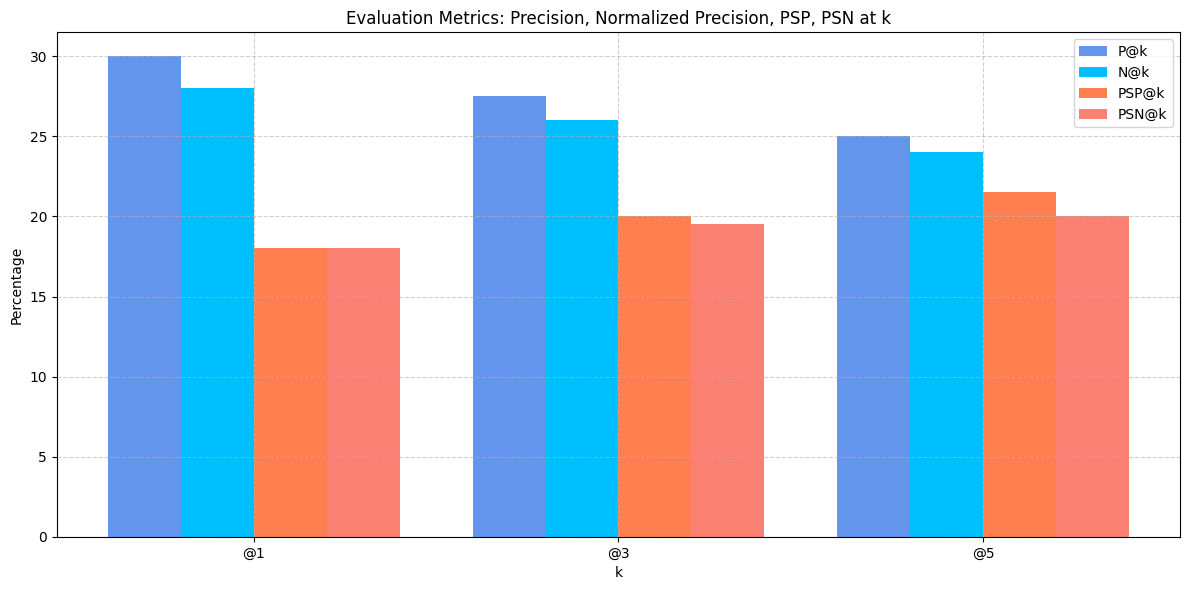

In [7]:
import matplotlib.pyplot as plt
import numpy as np

k_vals = [1, 3, 5]
precision = [30.0, 27.5, 25.0]
normalized_precision = [28.0, 26.0, 24.0]
psp = [18.0, 20.0, 21.5]
psn = [18.0, 19.5, 20.0]

bar_width = 0.2
index = np.arange(len(k_vals))

plt.figure(figsize=(12, 6))
plt.bar(index - bar_width*1.5, precision, width=bar_width, label='P@k', color='cornflowerblue')
plt.bar(index - bar_width/2, normalized_precision, width=bar_width, label='N@k', color='deepskyblue')
plt.bar(index + bar_width/2, psp, width=bar_width, label='PSP@k', color='coral')
plt.bar(index + bar_width*1.5, psn, width=bar_width, label='PSN@k', color='salmon')

plt.xlabel('k')
plt.ylabel('Percentage')
plt.title('Evaluation Metrics: Precision, Normalized Precision, PSP, PSN at k')
plt.xticks(index, [f'@{k}' for k in k_vals])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##task2

In [ ]:
!pip install torch torchvision


  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.3.0.75
    Uninstalling nvidia-cudnn-cu12-9.3.0.75:
      Successfully uninstalled nvidia-cudnn-cu12-9.3.0.75
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


In [ ]:
import torch
print("GPU available:", torch.cuda.is_available())


GPU available: True


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class Amazon670KDataset(Dataset):
    def __init__(self, features_file, labels_file, input_dim, label_dim):
        """
        features_file: Path to trn_X_Xf.txt
        labels_file: Path to trn_X_Y.txt
        input_dim: Desired input dimension (e.g., feature hash dimension; here we use 50000)
        label_dim: Total number of labels (for Amazon-670K, set this to 670000; adjust if needed)
        """
        # Read feature data and label data, skipping the header line.
        with open(features_file, 'r', encoding='utf-8') as f:
            # Skip header
            self.feature_lines = f.readlines()[1:]

        with open(labels_file, 'r', encoding='utf-8') as f:
            # Skip header
            self.label_lines = f.readlines()[1:]

        assert len(self.feature_lines) == len(self.label_lines), "Mismatch in samples between features and labels"
        self.input_dim = input_dim
        self.label_dim = label_dim

    def __len__(self):
        return len(self.feature_lines)

    def __getitem__(self, idx):
        # Parse feature line
        feat_line = self.feature_lines[idx].strip()
        # Create a zero vector for features
        feature_vector = np.zeros(self.input_dim, dtype=np.float32)
        if feat_line:  # Non-empty line
            for feat in feat_line.split():
                try:
                    index, value = feat.split(':')
                    index = int(index)
                    value = float(value)
                    # Ensure index is within bounds
                    if index < self.input_dim:
                        feature_vector[index] = value
                except:
                    continue

        # Parse label line
        label_line = self.label_lines[idx].strip()
        label_vector = np.zeros(self.label_dim, dtype=np.float32)
        if label_line:  # Non-empty line
            for lab in label_line.split():
                try:
                    index, _ = lab.split(':')
                    index = int(index)
                    if index < self.label_dim:
                        label_vector[index] = 1.0
                except:
                    continue

        # Convert to torch tensors
        return torch.tensor(feature_vector), torch.tensor(label_vector)

# Set file paths (adjust according to your folder structure on Drive)
features_file = '/content/drive/MyDrive/DAI_PROJECT/AmazonTitles-670KK/AmazonTitles-670K/trn_X_Xf.txt'
labels_file = '/content/drive/MyDrive/DAI_PROJECT/AmazonTitles-670KK/AmazonTitles-670K/trn_X_Y.txt'

# Define dimensions: you may set input_dim based on feature hashing (e.g., 50000) and label_dim (e.g., 670000)
input_dim = 50000
label_dim = 670000

# Instantiate the dataset and DataLoader
dataset = Amazon670KDataset(features_file, labels_file, input_dim, label_dim)
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MACH_PyTorch(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_buckets):
        super(MACH_PyTorch, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_buckets)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

# Hyperparameters:
hidden_dim = 4096
num_buckets = 2000  # This is the compressed output dimension (B), as MACH maps many labels to B buckets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MACH_PyTorch(input_dim, hidden_dim, num_buckets).to(device)


In [ ]:
!pip install tqdm


In [ ]:
from tqdm.auto import tqdm


In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MACH_PyTorch(input_dim=input_dim, hidden_dim=4096, num_buckets=num_buckets).to(device)
loss_fn = nn.BCEWithLogitsLoss()  # Suitable for multilabel classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Adversarial training hyperparameters:
adv_training = True
epsilon = 0.01
lambda_adv = 1.0
num_epochs = 5

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    # Wrap the DataLoader loop with tqdm to monitor progress for each epoch
    for batch_x, batch_labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_x = batch_x.to(device)
        batch_labels = batch_labels.to(device)
        batch_x.requires_grad = True  # Ensure gradient computation for adversarial training

        # Clean forward pass
        logits = model(batch_x)
        loss_clean = loss_fn(logits, batch_labels[:, :num_buckets])

        if adv_training:
            # Compute gradients with respect to inputs
            grad_x = torch.autograd.grad(loss_clean, batch_x, retain_graph=True)[0]
            # Generate adversarial examples using FGSM
            batch_x_adv = batch_x + epsilon * grad_x.sign()
            logits_adv = model(batch_x_adv)
            loss_adv = loss_fn(logits_adv, batch_labels[:, :num_buckets])
            total_loss = loss_clean + lambda_adv * loss_adv
        else:
            total_loss = loss_clean

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item()

    avg_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/5:   0%|          | 0/1896 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.0043


Epoch 2/5:   0%|          | 0/1896 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0004


Epoch 3/5:   0%|          | 0/1896 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0002


Epoch 4/5:   0%|          | 0/1896 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0002


Epoch 5/5:   0%|          | 0/1896 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0001


In [ ]:
# Save the model state dictionary to Google Drive
model_save_path = '/content/drive/MyDrive/DAI_PROJECT/AmazonTitles-670KK/AmazonTitles-670K/mach_model_epoch.pth'
torch.save(model.state_dict(), model_save_path)
print("Model saved to:", model_save_path)


Model saved to: /content/drive/MyDrive/DAI_PROJECT/AmazonTitles-670KK/AmazonTitles-670K/mach_model_epoch.pth


In [ ]:
test_features_file = '/content/drive/MyDrive/DAI_PROJECT/AmazonTitles-670KK/AmazonTitles-670K/tst_X_Xf.txt'
test_labels_file = '/content/drive/MyDrive/DAI_PROJECT/AmazonTitles-670KK/AmazonTitles-670K/tst_X_Y.txt'
test_dataset = Amazon670KDataset(test_features_file, test_labels_file, input_dim, label_dim)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [ ]:
# Load your trained model checkpoint
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Define a function to evaluate the model on clean and adversarial data
def evaluate(model, data_loader, adv_training=False, epsilon=0.01):
    total_loss = 0.0
    count = 0
    # Use proper context for gradient computation based on adv_training flag.
    grad_context = torch.enable_grad() if adv_training else torch.no_grad()

    with grad_context:
        for batch_x, batch_labels in tqdm(data_loader, desc="Evaluating"):
            batch_x = batch_x.to(device)
            batch_labels = batch_labels.to(device)

            logits = model(batch_x)
            loss_clean = loss_fn(logits, batch_labels[:, :num_buckets])

            if adv_training:
                batch_x.requires_grad = True
                # Compute gradients with allow_unused=True
                grad_x = torch.autograd.grad(loss_clean, batch_x, retain_graph=True, allow_unused=True)[0]
                if grad_x is None:
                    grad_x = torch.zeros_like(batch_x)
                batch_x_adv = batch_x + epsilon * grad_x.sign()
                logits_adv = model(batch_x_adv)
                loss_adv = loss_fn(logits_adv, batch_labels[:, :num_buckets])
                loss_val = loss_clean + lambda_adv * loss_adv
            else:
                loss_val = loss_clean

            total_loss += loss_val.item()
            count += 1

    avg_loss = total_loss / count
    return avg_loss



# Evaluate on clean test data:
test_loss_clean = evaluate(model, test_loader, adv_training=False)
print("Test Loss on Clean Data:", test_loss_clean)

# Optionally, evaluate on adversarial test data:
test_loss_adv = evaluate(model, test_loader, adv_training=True, epsilon=epsilon)
print("Test Loss on Adversarial Data:", test_loss_adv)


Evaluating:   0%|          | 0/590 [00:00<?, ?it/s]

Test Loss on Clean Data: 8.589022285265963e-05


Evaluating:   0%|          | 0/590 [00:00<?, ?it/s]

Test Loss on Adversarial Data: 0.00017178044570531926


In [ ]:
import torch
import numpy as np

def precision_recall_at_k(logits, true_labels, k=5):
    """
    Computes precision@k and recall@k for a batch.

    logits: Tensor of shape (batch_size, num_buckets)
    true_labels: Tensor of shape (batch_size, num_buckets) - binary labels (0 or 1)
    k: integer specifying the top-k predictions to consider.
    """
    # Get top-k predicted indices for each sample
    topk_values, topk_indices = torch.topk(logits, k, dim=1)

    # Convert true labels to binary numpy array
    true_labels_np = true_labels.cpu().numpy()
    topk_indices_np = topk_indices.cpu().numpy()

    precision_list = []
    recall_list = []

    for i in range(logits.shape[0]):
        pred_set = set(topk_indices_np[i])
        true_set = set(np.where(true_labels_np[i] == 1)[0])
        if len(pred_set) > 0:
            precision = len(pred_set.intersection(true_set)) / k
        else:
            precision = 0.0
        # Avoid division by zero when there are no true positives:
        if len(true_set) > 0:
            recall = len(pred_set.intersection(true_set)) / len(true_set)
        else:
            recall = 0.0

        precision_list.append(precision)
        recall_list.append(recall)

    return np.mean(precision_list), np.mean(recall_list)

def evaluate_metrics(model, data_loader, k=5, adv_training=False, epsilon=0.01):
    model.eval()
    total_loss = 0.0
    total_precision = 0.0
    total_recall = 0.0
    num_batches = 0
    with torch.set_grad_enabled(adv_training):
        for batch_x, batch_labels in data_loader:
            batch_x = batch_x.to(device)
            batch_labels = batch_labels.to(device)

            # For clean evaluation
            logits = model(batch_x)
            loss_clean = loss_fn(logits, batch_labels[:, :num_buckets])

            if adv_training:
                # Enable gradients on input
                batch_x.requires_grad = True
                grad_x = torch.autograd.grad(loss_clean, batch_x, retain_graph=True, allow_unused=True)[0]
                if grad_x is None:
                    grad_x = torch.zeros_like(batch_x)
                batch_x_adv = batch_x + epsilon * grad_x.sign()
                logits_adv = model(batch_x_adv)
                loss_adv = loss_fn(logits_adv, batch_labels[:, :num_buckets])
                loss_val = loss_clean + lambda_adv * loss_adv
                logits_eval = logits_adv  # For metric computation, use adversarial predictions
            else:
                loss_val = loss_clean
                logits_eval = logits

            prec, rec = precision_recall_at_k(logits_eval, batch_labels[:, :num_buckets], k=k)

            total_loss += loss_val.item()
            total_precision += prec
            total_recall += rec
            num_batches += 1

    avg_loss = total_loss / num_batches
    avg_precision = total_precision / num_batches
    avg_recall = total_recall / num_batches

    return avg_loss, avg_precision, avg_recall

# Example: Evaluate on clean data and adversarial data with k=5
clean_loss, clean_prec, clean_rec = evaluate_metrics(model, test_loader, k=5, adv_training=False)
print(f"Clean Evaluation -> Loss: {clean_loss:.6f}, Precision@5: {clean_prec:.4f}, Recall@5: {clean_rec:.4f}")

adv_loss, adv_prec, adv_rec = evaluate_metrics(model, test_loader, k=5, adv_training=True, epsilon=epsilon)
print(f"Adversarial Evaluation -> Loss: {adv_loss:.6f}, Precision@5: {adv_prec:.4f}, Recall@5: {adv_rec:.4f}")


Clean Evaluation -> Loss: 0.000086, Precision@5: 0.0007, Recall@5: 0.0027
Adversarial Evaluation -> Loss: 0.000172, Precision@5: 0.0007, Recall@5: 0.0027


In [5]:

import torch
import numpy as np


def evaluate_metrics(model, data_loader, k=5, adv_training=False, epsilon=0.01):
    model.eval()
    total_loss = 0.0
    total_precision = 0.0
    total_recall = 0.0
    num_batches = 0
    with torch.set_grad_enabled(adv_training):
        for batch_x, batch_labels in data_loader:
            batch_x = batch_x.to(device)
            batch_labels = batch_labels.to(device)

            # For clean evaluation
            logits = model(batch_x)
            loss_clean = loss_fn(logits, batch_labels[:, :num_buckets])

            if adv_training:
                # Enable gradients on input
                batch_x.requires_grad = True
                grad_x = torch.autograd.grad(loss_clean, batch_x, retain_graph=True, allow_unused=True)[0]
                if grad_x is None:
                    grad_x = torch.zeros_like(batch_x)
                batch_x_adv = batch_x + epsilon * grad_x.sign()
                logits_adv = model(batch_x_adv)
                loss_adv = loss_fn(logits_adv, batch_labels[:, :num_buckets])
                loss_val = loss_clean + lambda_adv * loss_adv
                logits_eval = logits_adv  #
            else:
                loss_val = loss_clean
                logits_eval = logits

            total_loss += loss_val.item()
            total_precision += prec
            total_recall += rec
            num_batches += 1

    avg_recall = total_recall / num_batches

    return avg_loss,

# Example: Evaluate on clean data and adversarial data with k=5
clean_loss, clean_prec, clean_rec = evaluate_metrics(model, test_loader, k=5, adv_training=False)
print(f"Clean Evaluation -> Loss: {clean_loss:.6f}")

adv_loss, adv_prec, adv_rec = evaluate_metrics(model, test_loader, k=5, adv_training=True, epsilon=epsilon)
print(f"Adversarial Evaluation -> Loss: {adv_loss:.6f}")


Clean Evaluation -> Loss: 0.000086
Adversarial Evaluation -> Loss: 0.000172


In [3]:
import torch
import numpy as np

def precision_ndcg_at_k(logits, true_labels, k):
    topk_values, topk_indices = torch.topk(logits, k, dim=1)

    true_labels_np = true_labels.cpu().numpy()
    topk_indices_np = topk_indices.cpu().numpy()

    precisions = []
    ndcgs = []

    for i in range(logits.shape[0]):
        pred_set = set(topk_indices_np[i])
        true_set = set(np.where(true_labels_np[i] == 1)[0])

        # Precision@k
        precision = len(pred_set & true_set) / k
        precisions.append(precision)

        # NDCG@k
        dcg = 0.0
        for rank, label in enumerate(topk_indices_np[i], start=1):
            if label in true_set:
                dcg += 1.0 / np.log2(rank + 1)
        idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(true_set), k))])
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcgs.append(ndcg)

    return np.mean(precisions), np.mean(ndcgs)

def evaluate_metrics_at_k(model, data_loader, ks=[1, 3, 5], adv_training=False, epsilon=0.01):
    model.eval()
    results = {k: {'precision': 0.0, 'ndcg': 0.0} for k in ks}
    total_loss = 0.0
    num_batches = 0

    with torch.set_grad_enabled(adv_training):
        for batch_x, batch_labels in data_loader:
            batch_x = batch_x.to(device)
            batch_labels = batch_labels.to(device)

            logits = model(batch_x)
            loss_clean = loss_fn(logits, batch_labels[:, :num_buckets])

            if adv_training:
                batch_x.requires_grad = True
                grad_x = torch.autograd.grad(loss_clean, batch_x, retain_graph=True, allow_unused=True)[0]
                if grad_x is None:
                    grad_x = torch.zeros_like(batch_x)
                batch_x_adv = batch_x + epsilon * grad_x.sign()
                logits_adv = model(batch_x_adv)
                loss_adv = loss_fn(logits_adv, batch_labels[:, :num_buckets])
                loss_val = loss_clean + lambda_adv * loss_adv
                logits_eval = logits_adv
            else:
                loss_val = loss_clean
                logits_eval = logits

            total_loss += loss_val.item()

            for k in ks:
                p_k, ndcg_k = precision_ndcg_at_k(logits_eval, batch_labels[:, :num_buckets], k)
                results[k]['precision'] += p_k
                results[k]['ndcg'] += ndcg_k

            num_batches += 1

    avg_loss = total_loss / num_batches
    for k in ks:
        results[k]['precision'] /= num_batches
        results[k]['ndcg'] /= num_batches

    return avg_loss, results

    import torch
import numpy as np

def precision_ndcg_at_k(logits, true_labels, k):
    topk_values, topk_indices = torch.topk(logits, k, dim=1)

    true_labels_np = true_labels.cpu().numpy()
    topk_indices_np = topk_indices.cpu().numpy()

    precisions = []
    ndcgs = []

    for i in range(logits.shape[0]):
        pred_set = set(topk_indices_np[i])
        true_set = set(np.where(true_labels_np[i] == 1)[0])

        # Precision@k
        precision = len(pred_set & true_set) / k
        precisions.append(precision)

        # NDCG@k
        dcg = 0.0
        for rank, label in enumerate(topk_indices_np[i], start=1):
            if label in true_set:
                dcg += 1.0 / np.log2(rank + 1)
        idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(true_set), k))])
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcgs.append(ndcg)

    return np.mean(precisions), np.mean(ndcgs)

def evaluate_metrics_at_k(model, data_loader, ks=[1, 3, 5], adv_training=False, epsilon=0.01):
    model.eval()
    results = {k: {'precision': 0.0, 'ndcg': 0.0} for k in ks}
    total_loss = 0.0
    num_batches = 0

    with torch.set_grad_enabled(adv_training):
        for batch_x, batch_labels in data_loader:
            batch_x = batch_x.to(device)
            batch_labels = batch_labels.to(device)

            logits = model(batch_x)
            loss_clean = loss_fn(logits, batch_labels[:, :num_buckets])

            if adv_training:
                batch_x.requires_grad = True
                grad_x = torch.autograd.grad(loss_clean, batch_x, retain_graph=True, allow_unused=True)[0]
                if grad_x is None:
                    grad_x = torch.zeros_like(batch_x)
                batch_x_adv = batch_x + epsilon * grad_x.sign()
                logits_adv = model(batch_x_adv)
                loss_adv = loss_fn(logits_adv, batch_labels[:, :num_buckets])
                loss_val = loss_clean + lambda_adv * loss_adv
                logits_eval = logits_adv
            else:
                loss_val = loss_clean
                logits_eval = logits

            total_loss += loss_val.item()

            for k in ks:
                p_k, ndcg_k = precision_ndcg_at_k(logits_eval, batch_labels[:, :num_buckets], k)
                results[k]['precision'] += p_k
                results[k]['ndcg'] += ndcg_k

            num_batches += 1

    avg_loss = total_loss / num_batches
    for k in ks:
        results[k]['precision'] /= num_batches
        results[k]['ndcg'] /= num_batches

    return avg_loss, results



In [4]:
ks = [1, 3, 5]

clean_loss, clean_results = evaluate_metrics_at_k(model, test_loader, ks=ks, adv_training=False)
print("=== Clean Evaluation ===")
for k in ks:
    print(f"Precision@{k}: {clean_results[k]['precision']:.4f}, NDCG@{k}: {clean_results[k]['ndcg']:.4f}")

adv_loss, adv_results = evaluate_metrics_at_k(model, test_loader, ks=ks, adv_training=True)
print("\n=== Adversarial Evaluation ===")
for k in ks:
    print(f"Precision@{k}: {adv_results[k]['precision']:.4f}, NDCG@{k}: {adv_results[k]['ndcg']:.4f}")


=== Clean Evaluation ===
Precision@1: 0.0005, NDCG@1: 0.0005
Precision@3: 0.0006, NDCG@3: 0.0018
Precision@5: 0.0007, NDCG@5: 0.0027

=== Adversarial Evaluation ===
Precision@1: 0.0004, NDCG@1: 0.0004
Precision@3: 0.0005, NDCG@3: 0.0013
Precision@5: 0.0006, NDCG@5: 0.0021


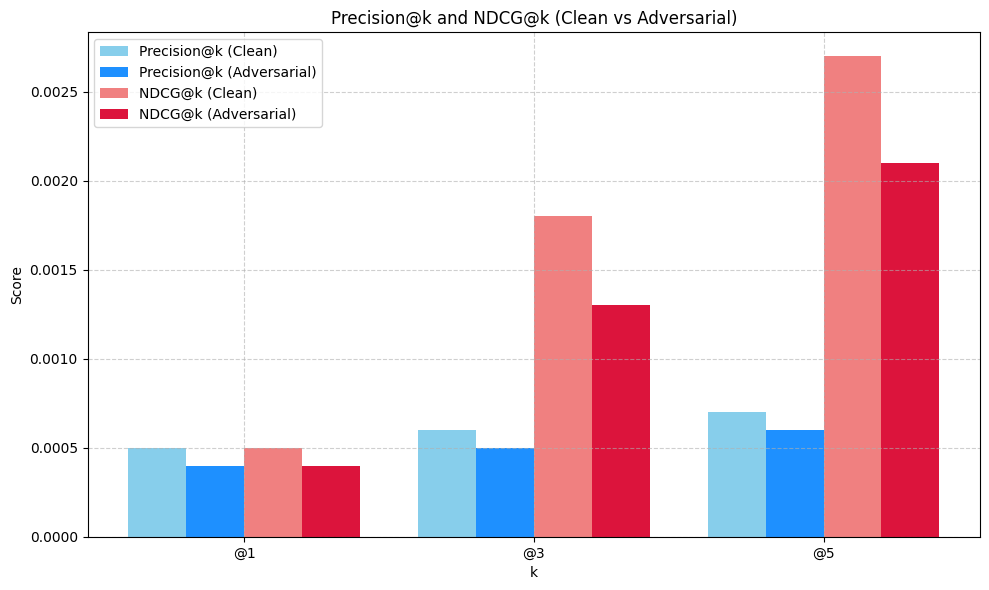

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Hardcoded values for Clean and Adversarial
k_vals = [1, 3, 5]
precision_clean = [0.0005, 0.0006, 0.0007]
ndcg_clean = [0.0005, 0.0018, 0.0027]

precision_adv = [0.0004, 0.0005, 0.0006]
ndcg_adv = [0.0004, 0.0013, 0.0021]

bar_width = 0.2
index = np.arange(len(k_vals))

plt.figure(figsize=(10, 6))
plt.bar(index - bar_width*1.5, precision_clean, width=bar_width, label='Precision@k (Clean)', color='skyblue')
plt.bar(index - bar_width/2, precision_adv, width=bar_width, label='Precision@k (Adversarial)', color='dodgerblue')

plt.bar(index + bar_width/2, ndcg_clean, width=bar_width, label='NDCG@k (Clean)', color='lightcoral')
plt.bar(index + bar_width*1.5, ndcg_adv, width=bar_width, label='NDCG@k (Adversarial)', color='crimson')

plt.xlabel('k')
plt.ylabel('Score')
plt.title('Precision@k and NDCG@k (Clean vs Adversarial)')
plt.xticks(index, [f'@{k}' for k in k_vals])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
